In [1]:
import random
import numpy as np

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

Dataset is modified [Restaurant](https://www.cs.utexas.edu/users/ml/riddle/data.html) dataset. Check [deduplication-slides](https://github.com/vintasoftware/deduplication-slides/) for more details.

In [2]:
import ast
import pandas as pd

df = pd.read_csv(
    'restaurant-with-latlng.csv',
    skip_blank_lines=True,
    converters={
        "postal": str,
        "latlng": ast.literal_eval
    })
df.head(9)

,name,addr,city,phone,type,cluster,postal,latlng
0,arnie morton's of chicago,435 s. la cienega blv.,los angeles,310/246-1501,american,0,90048,"(34.0707083, -118.3765626)"
1,arnie morton's of chicago,435 s. la cienega blvd.,los angeles,310-246-1501,steakhouses,0,90048,"(34.0707083, -118.3765626)"
2,arnie morton,435 s. la cienega boulevard,los angeles,310-246-1501,steakhouses,0,90048,"(34.0707083, -118.3765626)"
3,art's delicatessen,12224 ventura blvd.,studio city,818/762-1221,american,1,91604,"(34.1429632, -118.3994648)"
4,art's deli,12224 ventura blvd.,studio city,818-762-1221,delis,1,91604,"(34.1429632, -118.3994648)"
5,art's deli,12224 ventura blvd.,los angeles,818-762-1221,delis,1,91604,"(34.1429632, -118.3994648)"
6,hotel bel-air,701 stone canyon rd.,bel air,310/472-1211,californian,2,90077,"(34.0865944, -118.4463507)"
7,bel-air hotel,701 stone canyon rd.,bel air,310-472-1211,californian,2,90077,"(34.0865944, -118.4463507)"
8,bel-air,701 stone canyon road,bel air,(310) 472-1211,american,2,90077,"(34.0865944, -118.4463507)"


In [3]:
len(df)

881

In [4]:
import itertools

golden_pairs_set = {
    tuple(sorted(pair))
    for cluster_ids in df.groupby('cluster').indices.values()
    for pair in itertools.combinations(cluster_ids, 2)
}
len(golden_pairs_set)

150

In [5]:
from rf_dedupe import RFDedupe
import dedupe

fields = [
    {
        'field': 'name',
        'variable name': 'name',
        'type': 'String',
    },
    {
        'field': 'addr',
        'variable name': 'addr',
        'type': 'String',
    },
    {
        'field': 'postal',
        'variable name': 'postal',
        'type': 'String'
    },
    {
        'field': 'latlng',
        'variable name': 'latlng',
        'type': 'LatLong'
    },
]
deduper = RFDedupe(fields, num_cores=1)

In [6]:
data = (
    df
    .replace({np.nan: None})
    .replace({'': None})
    # assigning cluster for generating training,
    # not used by Dedupe
    .assign(cluster=df['cluster'])
    .to_dict('index')
)

In [7]:
import os

training_filename = 'dedupe-2-training.json'
with open(training_filename) as tf:
    deduper.prepare_training(data, tf)

# dedupe.console_label(deduper)

with open(training_filename, 'w') as tf:
    deduper.write_training(tf)

deduper.train(index_predicates=False)

INFO:dedupe.api:reading training from file
INFO:dedupe.training:Final predicate set:
INFO:dedupe.training:(SimplePredicate: (oneGramFingerprint, addr), SimplePredicate: (wholeFieldPredicate, name))
INFO:dedupe.training:Final predicate set:
INFO:dedupe.training:(SimplePredicate: (sameFiveCharStartPredicate, addr), SimplePredicate: (sameThreeCharStartPredicate, name))
INFO:dedupe.training:(SimplePredicate: (commonTwoTokens, name), SimplePredicate: (twoGramFingerprint, name))
INFO:dedupe.training:(SimplePredicate: (sameSevenCharStartPredicate, name), SimplePredicate: (suffixArray, addr))
INFO:dedupe.training:Final predicate set:
INFO:dedupe.training:(SimplePredicate: (sameFiveCharStartPredicate, addr), SimplePredicate: (sameThreeCharStartPredicate, name))
INFO:dedupe.training:(SimplePredicate: (commonTwoTokens, name), SimplePredicate: (twoGramFingerprint, name))
INFO:dedupe.training:(SimplePredicate: (sameSevenCharStartPredicate, name), SimplePredicate: (suffixArray, addr))


In [8]:
pairs = deduper.pairs(data)
pair_scores = deduper.score(pairs)
pair_scores[0]

([0, 1], 0.98)

In [9]:
unclustered_pairs_set = set(tuple(pair) for pair in pair_scores['pairs'])

In [10]:
# https://en.wikipedia.org/wiki/Precision_and_recall

def precision(found_pairs, true_pairs):
    true_positives = true_pairs & found_pairs
    return len(true_positives) / len(found_pairs)

def recall(found_pairs, true_pairs):
    true_positives = true_pairs & found_pairs
    return len(true_positives) / len(true_pairs)

## HAC (Dedupe's current method)

In [11]:
threshold = 0.5
clusters = list(deduper.cluster(pair_scores, threshold))
clusters[0]

((0, 1, 2), array([0.98585788, 0.98585788, 1.        ]))

In [12]:
dedupe_pairs_set = {
    tuple(sorted(pair))
    for cluster, __ in clusters
    for pair in itertools.combinations(cluster, 2)
}

In [13]:
print('HAC precision:', precision(dedupe_pairs_set, golden_pairs_set))
print('HAC recall:', recall(dedupe_pairs_set, golden_pairs_set))

HAC precision: 1.0
HAC recall: 0.8933333333333333


**Note: All libraries below *do* use edge weight. This is a thing to watch for, as there are various non-weighted community detection algorithms.**

## Louvain

https://github.com/taynaud/python-louvain

In [14]:
import networkx as nx

In [15]:
G = nx.Graph()
G.add_weighted_edges_from((x, y, score) for [x, y], score in pair_scores)

In [16]:
import community as community_louvain
louvain_partition = community_louvain.best_partition(G)
list(louvain_partition.values())[:3]

[0, 0, 0]

In [17]:
from collections import defaultdict

def partition_dict_to_pairs_set(partition):
    d = defaultdict(list)
    for id_, cluster_id in partition.items():
        d[cluster_id].append(id_)
    return set(
        id_pair
        for cluster in d.values()
        for id_pair in itertools.combinations(cluster, 2))

In [18]:
louvain_pairs_set = partition_dict_to_pairs_set(louvain_partition)

In [19]:
print('louvain precision:', precision(louvain_pairs_set, golden_pairs_set))
print('cluster recall:', recall(louvain_pairs_set, golden_pairs_set))

louvain precision: 0.9791666666666666
cluster recall: 0.94


## Leiden

https://github.com/vtraag/leidenalg

In [20]:
import igraph as ig

In [21]:
import leidenalg

In [22]:
igraph_G = ig.Graph(len(G), list(zip(*list(zip(*nx.to_edgelist(G)))[:2])))

In [23]:
igraph_G.es["weight"] = list(nx.get_edge_attributes(G, 'weight').values())

In [24]:
leiden_partition_obj = leidenalg.find_partition(igraph_G, leidenalg.ModularityVertexPartition)
leiden_partition_obj.membership[0:3]

[4, 4, 4]

In [25]:
leiden_partition = dict(enumerate(leiden_partition_obj.membership))

In [26]:
leiden_pairs_set = partition_dict_to_pairs_set(leiden_partition)

In [27]:
print('leiden precision:', precision(leiden_pairs_set, golden_pairs_set))
print('cluster recall:', recall(leiden_pairs_set, golden_pairs_set))

leiden precision: 0.9657534246575342
cluster recall: 0.94


## Infomap

In [28]:
infomap_partition_obj = igraph_G.community_infomap(edge_weights='weight')
infomap_partition_obj.membership[0:3]

[0, 0, 0]

In [29]:
infomap_partition = dict(enumerate(infomap_partition_obj.membership))

In [30]:
infomap_pairs_set = partition_dict_to_pairs_set(infomap_partition)

In [31]:
print('infomap precision:', precision(infomap_pairs_set, golden_pairs_set))
print('cluster recall:', recall(infomap_pairs_set, golden_pairs_set))

infomap precision: 0.9791666666666666
cluster recall: 0.94


## Debugging differences

In [32]:
dedupe_pairs_set - louvain_pairs_set

set()

In [33]:
louvain_pairs_set - dedupe_pairs_set

{(34, 35),
 (34, 36),
 (35, 37),
 (36, 37),
 (136, 137),
 (140, 141),
 (196, 198),
 (200, 839),
 (237, 238),
 (378, 379)}

In [34]:
score_dict = nx.get_edge_attributes(G, 'weight')

### Better?

,name,addr,city,phone,type,cluster,postal,latlng
34,locanda veneta,3rd st.,los angeles,310/274-1893,italian,13,,"(34.0090307, -118.4881742)"
35,locanda veneta,8638 w. third st.,los angeles,310-274-1893,italian,13,90048,"(34.0734209, -118.3810981)"
36,locanda veneta,8638 w 3rd,st los angeles,+1 310-274-1893,italian,13,90048,"(34.0734209, -118.3810981)"
37,locanda,w. third st.,st los angeles,+1 310-274-1893,italian,13,,"(34.0689472, -118.3225988)"


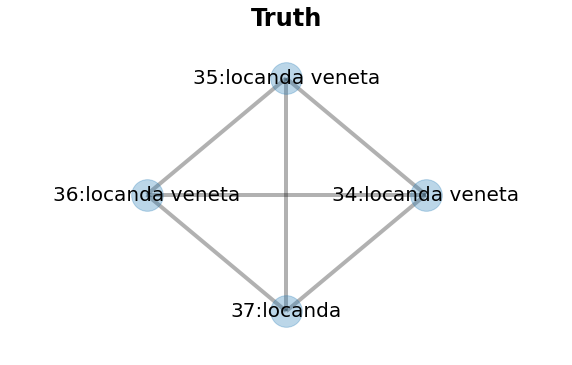

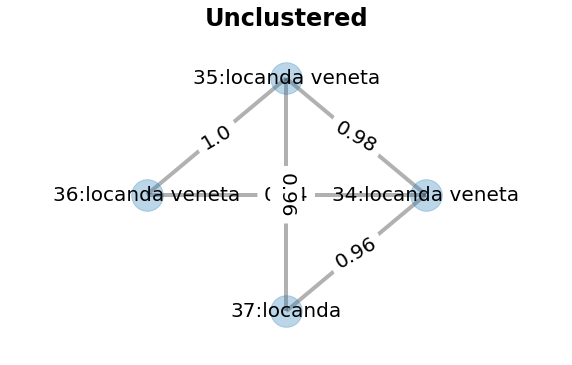

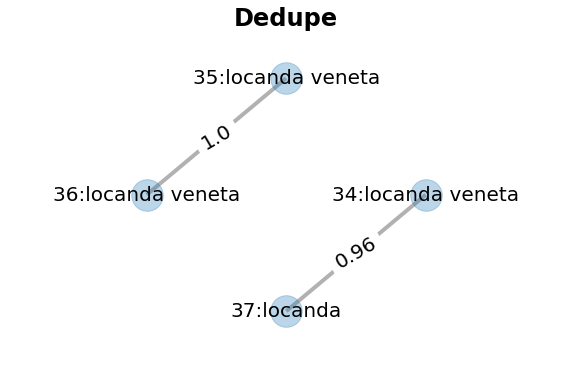

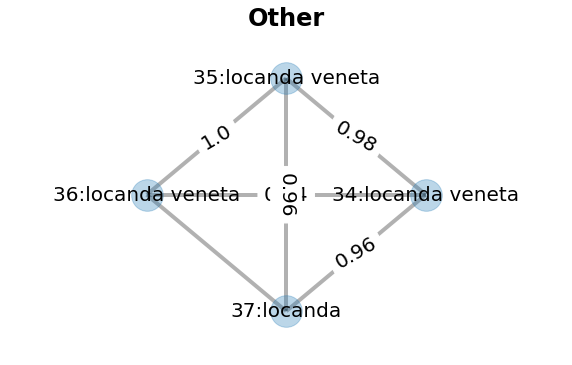

In [35]:
from debug_utils import show_cluster_graphs

ids_of_interest = {34, 35, 36, 37}

show_cluster_graphs(
    df=df,
    golden_pairs=golden_pairs_set,
    unclustered_pairs=unclustered_pairs_set,
    dedupe_pairs=dedupe_pairs_set,
    other_pairs=louvain_pairs_set,
    score_dict=score_dict,
    ids_of_interest=ids_of_interest
)

### Worse?

How to apply threshold here?

,name,addr,city,phone,type,cluster,postal,latlng
200,ritz-carlton restaurant,181 peachtree st.,atlanta,404-659-0400,french (classic),91,30303,"(33.75857209999999, -84.38718109999999)"
839,ritz-carlton cafe (atlanta),181 peachtree st.,atlanta,404-659-0400,american (new),711,30303,"(33.75857209999999, -84.38718109999999)"
199,restaurant ritz-carlton atlanta,181 peachtree st.,atlanta,404/659-0400,continental,91,30303,"(33.75857209999999, -84.38718109999999)"


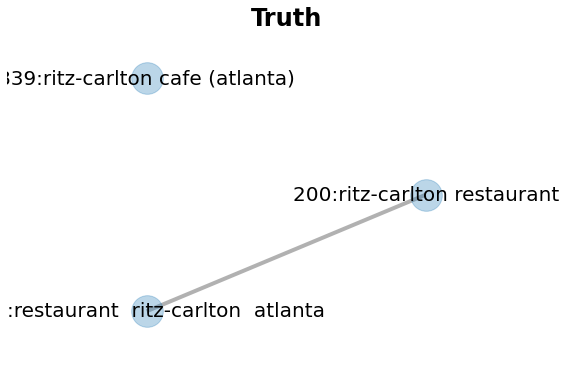

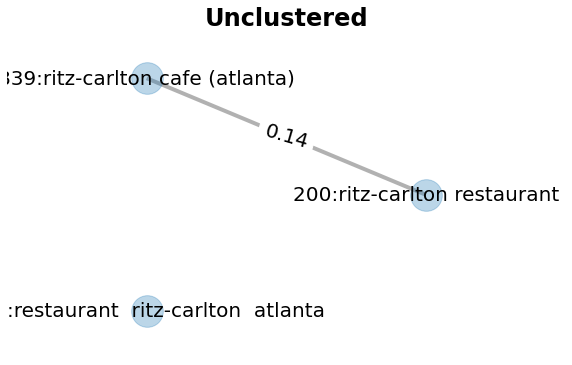

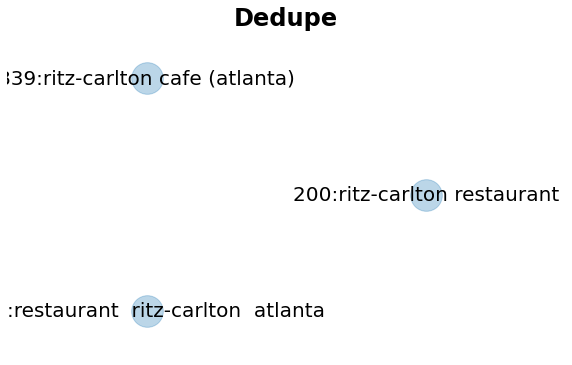

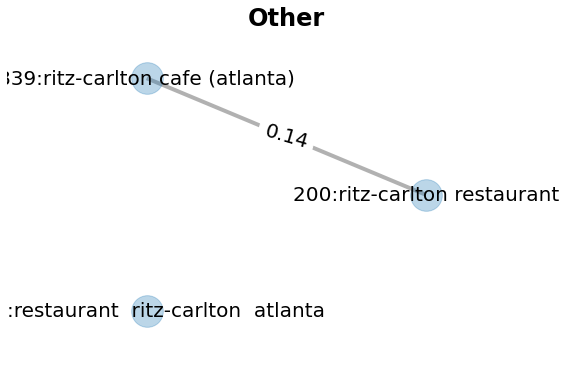

In [36]:
ids_of_interest = {199, 200, 839}

show_cluster_graphs(
    df=df,
    golden_pairs=golden_pairs_set,
    unclustered_pairs=unclustered_pairs_set,
    dedupe_pairs=dedupe_pairs_set,
    other_pairs=louvain_pairs_set,
    score_dict=score_dict,
    ids_of_interest=ids_of_interest
)